## Face and Facial Keypoint Detection

After the neural network is trained, it's ready to detect facial keypoints on *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to do that, first we need to extract any available faces in the image. Below is the outline of the pipeline:

1. Detect all the faces in an image using a Haar Cascade detector.
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that the model expects. This step is similar to the `data_transform` function created and applied in Notebook 1, where we rescaled, normalized, and turned image into a Tensor.
3. Use the trained model to detect facial keypoints on the image.

---

## Notebook Planning

1. Loading Model
2. Importing image
3. Extracting Faces
4. Identify facial keypoints
5. Conclusion

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2

import torch
from models import Net

## 1. Loading the model


In [2]:
net = Net()

net.load_state_dict(torch.load('keypoints_model_1.pt', map_location=torch.device('cpu')))

net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (dense1): Linear(in_features=8192, out_features=3000, bias=True)
  (dense2): Linear(in_features=3000, out_features=800, bias=True)
  (dense3): Linear(in_features=800, out_features=136, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (drop5): Dropout(p=0.4, inplace=False)
  (drop6): Dropout(p=0.4, inplace=False)
  (drop7): Dropout(p=0.4, inplace=False)
)

## 2. Importing Image


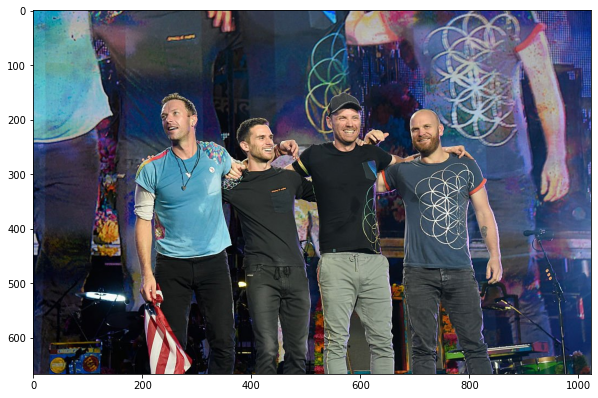

In [5]:
image = cv2.imread('Images/coldplay.jpeg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plotting the image
fig = plt.figure(figsize=(10,10))
plt.imshow(image)

## 3. Extracting Faces

Utilizing OpenCV's pre-trained Haar Cascade classifiers to find any faces in the image.

In the code below, we loop over each face in the original image and draw a red square on each face.


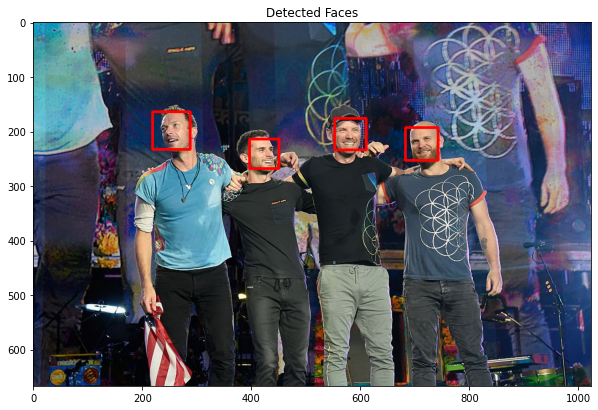

In [6]:
def extract_faces(image):
  # Loading Haar cascade classifier for detecting frontal faces
  face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

  # Using the classifier to detect faces
  # The output here is an array of detections; the corners of each detection box
  faces = face_cascade.detectMultiScale(image, 1.2, 2)

  # Making a copy of the original image to plot detections on
  image_with_detections = image.copy()

  # Looping over the detected faces, mark the image where each face is found
  for (x,y,w,h) in faces:
      cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

  fig = plt.figure(figsize=(10,10))
  plt.imshow(image_with_detections)
  plt.title('Detected Faces')
  return faces

faces = extract_faces(image)

## 4. Detect Facial Keypoints

Now, let's loop over each detected face in the image and transform them as follows:

1. Convert the face from RGB to grayscale.
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255].
3. Rescale the detected face to be the expected square size for the CNN model. (224x224, suggested)
4. Reshape the numpy image into a torch image.

After transforming the images, they are passed to the model and end up with keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:




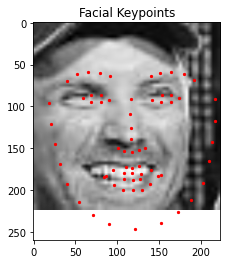

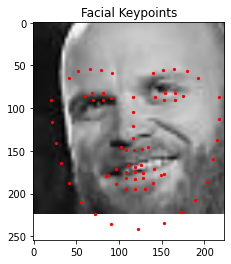

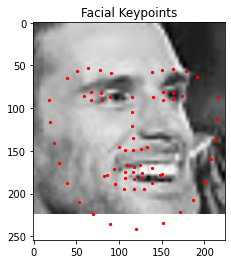

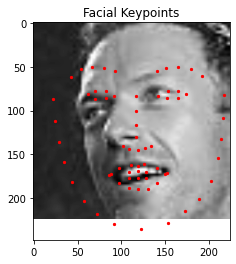

In [7]:
def show_keypoints(image, faces):

  # loop over the detected faces from your haar cascade
  for (x,y,w,h) in faces:

    # Select the region of interest that is the face in the image 
    roi = image[y:y+h, x:x+w]
    
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    roi = roi/225.0
    roi = cv2.resize(roi,(224,224))
    roi_np = roi.copy()
    
    # Reshaping the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    roi = roi.reshape(1, 1, roi.shape[0], roi.shape[1])
    # As the model takes a batch of images, when we passed the train batch, it had size [128,1,224,224]. Now it'll be [1,1,224,224]
    roi_t = torch.from_numpy(roi).type(torch.FloatTensor)
    
    
    # Make facial keypoint predictions using the loaded, trained network 
    with torch.no_grad():
        key_pts = net(roi_t) # shape will be [1,138]
    
    # As this is in tensor and wrapped in variable, have to take out of variable (.data) and convert to numpy
    key_pts = key_pts.view(68, -1).data.numpy() #This works because we have only 1 image and only 1 set of points
    
    # Adjusting the scaling parameters so that points fit the face
    key_pts = key_pts*90.0+90
    
    plt.figure()
    plt.imshow(roi_np, cmap='gray')
    plt.scatter(key_pts[:,0], key_pts[:,1], s=20, marker='.', c='r')
    plt.title('Facial Keypoints')
    plt.show()

show_keypoints(image, faces)

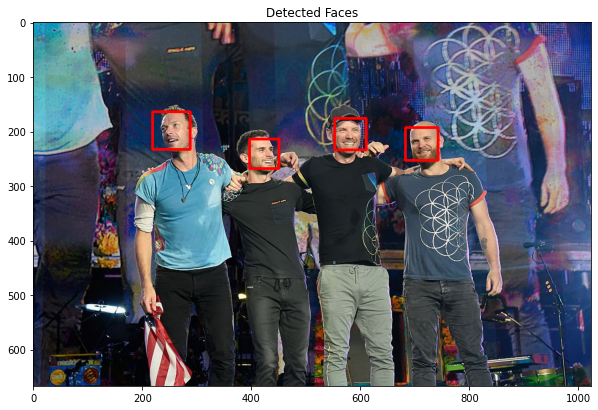

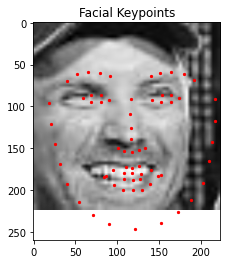

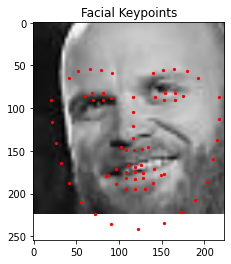

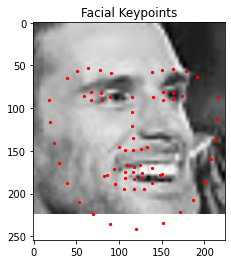

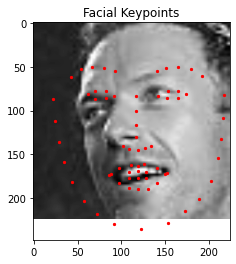

In [8]:
# Grouping all above tasks into single function to call anytime
def extract_keypoints(image_path):

  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  faces = extract_faces(image)
  show_keypoints(image, faces)

extract_keypoints('Images/coldplay.jpeg')

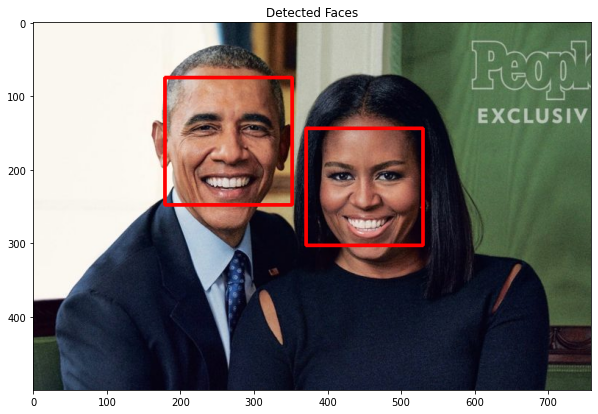

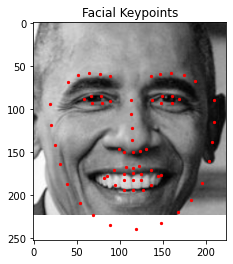

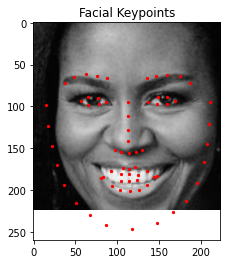

In [9]:
extract_keypoints('Images/obamas.jpg')

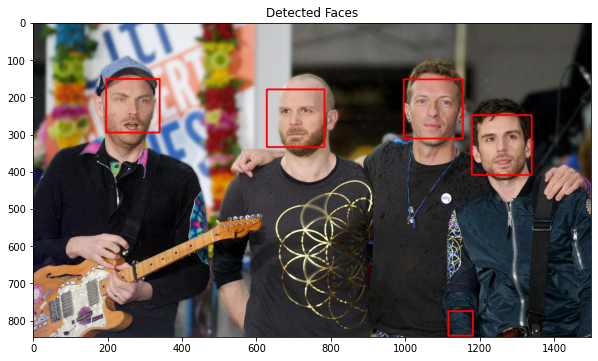

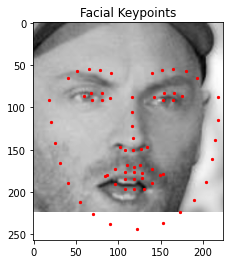

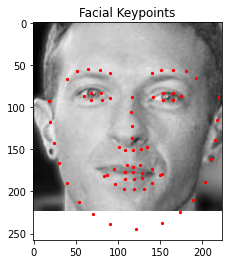

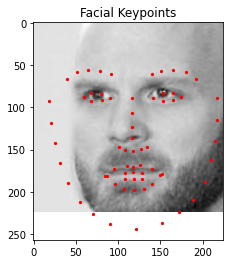

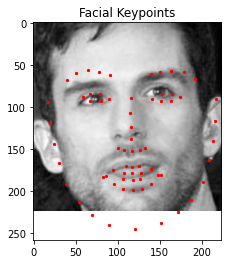

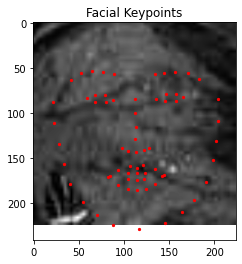

In [11]:
extract_keypoints('Images/coldplay1.jpg')

## 5. Conclusion

The Haar Cascase CLaasifier is detecting and extracting faces out of the image and our trained model is identifying the facial keypoints.   
The model is performing very well at mapping the landmarks at eyebrows, eyes, nose, lips and jawline.   
However, the Haar classifier is detedting false faces sometimes, resulting in false positives.   
Also, the system can be further improved to map landmarks of turned faces which is currently perofrming satisfactorily.